In [ ]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

### PASCAL VOC 2007 데이터 세트 다운로드

In [2]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

--2021-10-13 04:52:16--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-10-13 04:52:16--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  55.3MB/s    in 8.6s    

2021-10-13 04:52:25 (50.8 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



### MMDetection은 Mask RCNN을 학습하기 위해서는 COCO 포맷을 가장 선호
* CocoDataset으로 지정해야만, evaluation 시 mask evaluation 정보 제공.(2021년 6월 기준) https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html
* Pascal voc 포맷을 Coco 포맷으로 변환할 수 있는 유틸리티를 활용하여 데이터 변환
https://github.com/ISSResearch/Dataset-Converters
* Dataset converter 패키지가 opencv를 3.4로 downgrade함에 유의

In [3]:
import cv2
print(cv2.__version__)

4.1.2


In [4]:
!git clone https://github.com/ISSResearch/Dataset-Converters.git

Cloning into 'Dataset-Converters'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 54 (delta 3), reused 10 (delta 2), pack-reused 39
Unpacking objects: 100% (54/54), done.


In [5]:
!cd Dataset-Converters; pip install -r requirements.txt

     |████████████████████████████████| 47.9 MB 13 kB/s 
     |████████████████████████████████| 472 kB 41.7 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=b2b8ce677fe3aab95e2ca401072f40cd3d941598e667b07d33d30fbc557688e0
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=905a70dad33de55397105547e72c046d7b5f5df4ef54fca30b0da19cc2799778
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built dicttoxml typing
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully unins

In [6]:
!mkdir /content/coco_output
!cd Dataset-Converters; python convert.py --input-folder /content/VOCdevkit/VOC2007 --output-folder /content/coco_output \
                                            --input-format VOCSEGM --output-format COCO --copy

In [ ]:
!pip install opencv-python==4.1.2.30

### 생성된 Coco Annotation json 파일 살펴 보기

In [8]:
!sudo apt-get install jq

In [9]:
!jq . /content/coco_output/annotations/train.json >> output.json

In [ ]:
!head -200 output.json

In [ ]:
!grep -n 'annotations' output.json

In [ ]:
!head -1600 output.json | tail -400 

### Pretrained 모델 다운로드 및 Config, Dataset설정.

In [13]:
!cd mmdetection; mkdir checkpoints

In [14]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2021-10-13 04:54:06--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  7.47MB/s    in 33s     

2021-10-13 04:54:41 (7.35 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [15]:
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [16]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class VOCDataset(CocoDataset):
    CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
               'tvmonitor')

In [17]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [18]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'VOCDataset'
cfg.data_root = '/content/coco_output/'

cfg.data.train.type = 'VOCDataset'
cfg.data.train.data_root = '/content/coco_output/'
cfg.data.train.ann_file = 'annotations/train.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'VOCDataset'
cfg.data.val.data_root = '/content/coco_output/'
cfg.data.val.ann_file = 'annotations/val.json'
cfg.data.val.img_prefix = 'val'

cfg.model.roi_head.bbox_head.num_classes = 20
cfg.model.roi_head.mask_head.num_classes = 20

cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10


cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.lr_config.policy = 'step'
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [19]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [20]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [21]:
import os
from mmdet.apis import init_detector, inference_detector
import mmcv

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-10-13 04:55:26,913 - mmdet - INFO - load checkpoint from /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
2021-10-13 04:55:26,920 - mmdet - INFO - Use load_from_local loader


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2021-10-13 04:55:27,164 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([21, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([21]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([80]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 213/213, 2.0 task/s, elapsed: 104s, ETA:     0s

2021-10-13 05:44:42,699 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...


2021-10-13 05:44:43,494 - mmdet - INFO - Evaluating segm...


DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.785
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.660
Loading and pre

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/datasets/coco.py:454: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.57s).
Accumulating evaluation results...


2021-10-13 05:44:44,381 - mmdet - INFO - Epoch(val) [12][213]	bbox_mAP: 0.4990, bbox_mAP_50: 0.7850, bbox_mAP_75: 0.5620, bbox_mAP_s: 0.2770, bbox_mAP_m: 0.5080, bbox_mAP_l: 0.5600, bbox_mAP_copypaste: 0.499 0.785 0.562 0.277 0.508 0.560, segm_mAP: 0.4660, segm_mAP_50: 0.7160, segm_mAP_75: 0.5220, segm_mAP_s: 0.1530, segm_mAP_m: 0.4270, segm_mAP_l: 0.5820, segm_mAP_copypaste: 0.466 0.716 0.522 0.153 0.427 0.582


DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.650


### 학습된 모델을 이용하여 단일 이미지와 Video Inference 수행. 

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


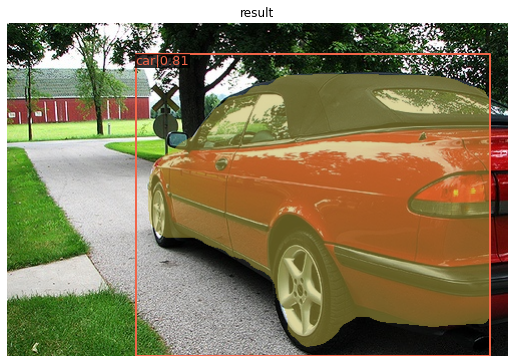

In [23]:
from mmdet.apis import show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

img = cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000007.jpg')

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

### Video Inference 수행
* get_detected_img()함수를 이용하여 Inference 수행. 

In [24]:
!wget -O /content/data/London_Street.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/London_Street.mp4?raw=true

/content/data/London_Street.mp4: No such file or directory


In [25]:
import numpy as np

labels_to_names_seq =  {0:'aeroplane', 1:'bicycle', 2:'bird', 3:'boat', 4:'bottle', 5:'bus', 6:'car',
               7:'cat', 8:'chair', 9:'cow', 10:'diningtable', 11:'dog', 12:'horse',
               13:'motorbike', 14:'person', 15:'pottedplant', 16:'sheep', 17:'sofa', 18:'train',
               19:'tvmonitor'}
  
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [26]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음. 
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(bbox_result) == 0:
      continue
    
    mask_array_list = seg_results[result_ind]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출. 
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출. 
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]
        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림. 
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        if is_print:
          print(caption)
  
  return draw_img


In [27]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold,is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [28]:
do_detected_video(model_ckpt, '/content/data/London_Street.mp4', '/content/data/London_Street_out01.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 0
더 이상 처리할 frame이 없습니다.
최종 detection 완료 수행 시간: 0.0008
